A recreation of <https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html>

# Regression: Sparse Variational Gaussian Process for Stochastic Optimisation with Flux.jl

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/ApproximateGPs.jl/blob/master/examples/a-regression/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/ApproximateGPs.jl/dev/examples/a-regression/).*

In this example, we show how to construct and train the stochastic variational
Gaussian process (SVGP) model for efficient inference in large scale datasets.
For a basic introduction to the functionality of this library, please refer to
the User Guide.

## Setup

In [1]:
using ApproximateGPs
using Distributions
using LinearAlgebra

using Plots
# We output plots as PNG to reduce their size
default(; fmt=:png, palette=:seaborn_colorblind, legend=:outertopright, size=(700, 400))
# Regardless of the `fmt` setting, by default Literate saves also the SVG output
# in notebooks: https://github.com/fredrikekre/Literate.jl/issues/61
# We use DisplayAs to ensure that only the PNG output is saved.
using DisplayAs

using Random
Random.seed!(1234);

## Generate some training data

We define a data-generating function `g`:

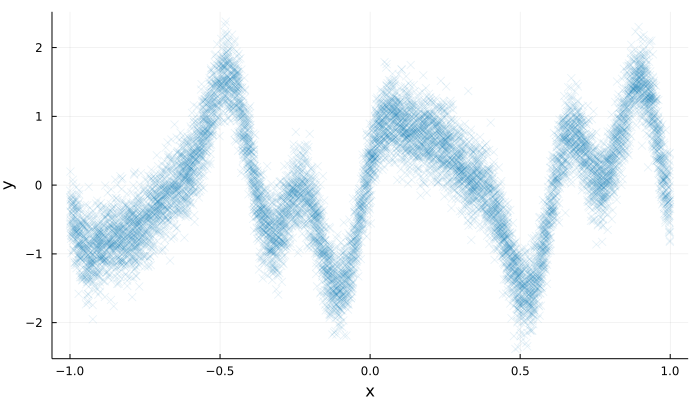

In [2]:
g(x) = sin(3π * x) + 0.3 * cos(9π * x) + 0.5 * sin(7π * x)

N = 10000 # Number of training points
x = rand(Uniform(-1, 1), N)
y = g.(x) + 0.3 * randn(N)

scatter(x, y; xlabel="x", ylabel="y", markershape=:xcross, markeralpha=0.1, legend=false)
DisplayAs.PNG(current())

## Set up a Flux model

We shall use the excellent framework provided by [Flux.jl](https://fluxml.ai/)
to perform stochastic optimisation. The SVGP approximation has three sets of
parameters to optimise - the inducing input locations, the mean and covariance
of the variational distribution `q` and the parameters of the
kernel.

First, we define a helper function to construct the kernel from its
parameters (often called kernel hyperparameters), and pick some
initial values `k_init`. Since Flux performs optimisation on
unconstrained parameters, we need to use softplus to ensure that the
kernel parameters are positive.

In [3]:
using StatsFuns: softplus, invsoftplus

function make_kernel(k_params)
    variance = softplus(k_params[1])
    lengthscale = softplus(k_params[2])
    return variance * with_lengthscale(SqExponentialKernel(), lengthscale)
end

init_variance = 1.3
init_lengthscale = 0.3
k_init = [invsoftplus(init_variance), invsoftplus(init_lengthscale)];

Then, we select some inducing input locations `z_init`. In this
case, we simply choose the first `M` data inputs.

In [4]:
M = 20 # number of inducing points
z_init = x[1:M];

Given a set of parameters, we now define a Flux 'layer' which forms
the basis of our model.

In [5]:
using Flux

struct SVGPModel
    k  # kernel parameters
    z  # inducing points
    m  # variational mean
    A  # square-root of variational covariance
end

Flux.@functor SVGPModel (k, z, m, A);

Set the observation noise for our model, along with a `jitter` term
to help with numerical stability.

In [6]:
lik_noise = 0.3
jitter = 1e-5;

Next, we define some useful functions on the model - creating the prior GP
under the model, as well as the `SparseVariationalApproximation` struct
needed to create the posterior approximation and to compute the ELBO.

In [7]:
function prior(m::SVGPModel)
    kernel = make_kernel(m.k)
    return GP(kernel)
end

prior (generic function with 1 method)

The variational distribution is given by `q(u)` where ``u ~ f(z)`` are the
pseudo-points. We parameterise the covariance matrix of ``q`` as ``S = A A^T``
since this guarantees that ``S`` is positive definite. We also only use the
lower triangular part of `A`, to ensure the minimum number of free parameters.

In [8]:
using PDMats: PDMat

function make_approx(m::SVGPModel, prior)
    # Efficiently constructs S as A*Aᵀ
    S = PDMat(Cholesky(LowerTriangular(m.A)))
    q = MvNormal(m.m, S)
    fz = prior(m.z, jitter)
    return SparseVariationalApproximation(fz, q)
end;

Create the approximate posterior GP under the model.

In [9]:
function model_posterior(m::SVGPModel)
    svgp = make_approx(m, prior(m))
    return posterior(svgp)
end;

Define a predictive function for the model - in this case the prediction is
the joint distribution of the approximate posterior GP at some test inputs `x`
(defined by an `AbstractGPs.FiniteGP`).

In [10]:
function (m::SVGPModel)(x)
    post = model_posterior(m)
    return post(x)
end;

Return the loss given data - for the SVGP model as constructed using `SparseVariationalApproximation`, the
loss used is the negative ELBO (also known as the Variational Free Energy).
`num_data` is required for minibatching used below.

In [11]:
function loss(m::SVGPModel, x, y; num_data=length(y))
    f = prior(m)
    fx = f(x, lik_noise)
    svgp = make_approx(m, f)
    return -elbo(svgp, fx, y; num_data)
end;

Finally, we choose some initial parameters and instantiate our model.

In [12]:
m_init = zeros(M)
A_init = Matrix{Float64}(I, M, M)

model = SVGPModel(k_init, z_init, m_init, A_init);

Taking a look at the model posterior under these initial parameters shows a
very poor fit to the data, as expected:

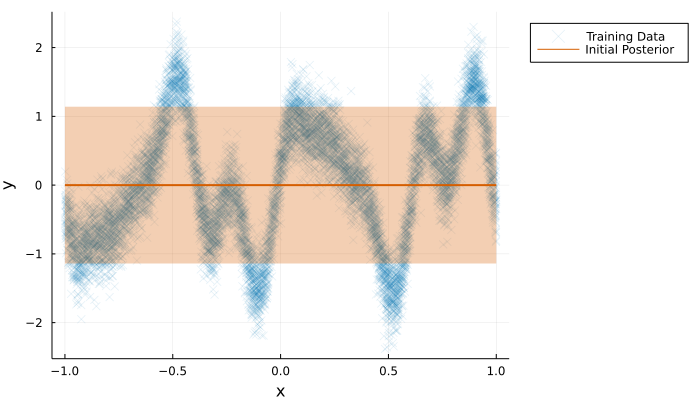

In [13]:
init_post = model_posterior(model)
scatter(
    x,
    y;
    xlabel="x",
    ylabel="y",
    markershape=:xcross,
    markeralpha=0.1,
    label="Training Data",
)
plot!(-1:0.001:1, init_post; label="Initial Posterior", color=4)
DisplayAs.PNG(current())

## Training the model

Training the model now simply proceeds with the usual `Flux.jl` training loop.

In [14]:
opt = ADAM(0.001)  # Define the optimiser
params = Flux.params(model);  # Extract the model parameters

One of the major advantages of the SVGP model is that it allows stochastic
estimation of the ELBO by using minibatching of the training data. This is
very straightforward to achieve with `Flux.jl`'s utilities:

In [15]:
b = 100 # minibatch size
data_loader = Flux.Data.DataLoader((x, y); batchsize=b)

Flux.Data.DataLoader{Tuple{Vector{Float64}, Vector{Float64}}, Random._GLOBAL_RNG}(([0.18168927733142048, 0.5335940730045183, 0.13247483301237173, -0.07982931507496582, 0.5880514206635885, 0.7082931807581003, -0.5988279301323178, -0.4027714433131764, -0.506325626779982, 0.15934446673808322  …  0.20228213333532974, 0.43128929722102516, -0.013851089501626834, -0.842007186496295, 0.9449592233807151, 0.11531570335622465, 0.8855698790802209, 0.21268746214945766, 0.963327954905584, -0.9888915520035928], [0.830715721094028, -1.994972979913132, 0.17529353265183645, -1.6186491595601078, -0.8923379243645142, 0.497453723631885, 0.45441028902775493, 0.7050880663863939, 1.7398168868800505, 0.8263166696284232  …  1.069157780939488, -0.2150177342239235, 0.46303759954707346, 0.0031137864385547553, 0.5510615580321441, 0.9913944243820315, 1.536633245555434, 0.8383240177185101, 0.46951872861675414, -0.9464875620164421]), 100, 10000, true, 10000, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  9991, 9992, 9993, 9994, 9

The loss (negative ELBO) before training

In [16]:
loss(model, x, y)

37436.40140920067

Train the model. N.B. when using minibatching, the length of the
full dataset `num_data` must be passed to the loss.

In [17]:
using IterTools: ncycle

Flux.train!(
    (x, y) -> loss(model, x, y; num_data=N),
    params,
    ncycle(data_loader, 300), # Train for 300 epochs
    opt,
);

Negative ELBO after training

In [18]:
loss(model, x, y)

5030.856699118618

Finally, we plot the optimised approximate posterior to see the
results.

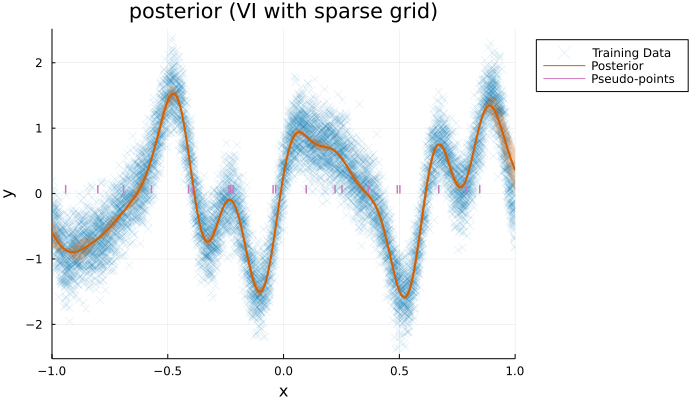

In [19]:
post = model_posterior(model)

scatter(
    x,
    y;
    markershape=:xcross,
    markeralpha=0.1,
    xlim=(-1, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (VI with sparse grid)",
    label="Training Data",
    color=1,
)
plot!(-1:0.001:1, post; label="Posterior", color=4)
sticks!(model.z, fill(0.13, M); label="Pseudo-points", linewidth=1.5, color=5)
DisplayAs.PNG(current())

### Package and system information
#### Package version
```julia
      Status `~/work/ApproximateGPs.jl/ApproximateGPs.jl/examples/a-regression/Project.toml`
  [298c2ebc] ApproximateGPs v0.2.8
  [0b91fe84] DisplayAs v0.1.4
  [31c24e10] Distributions v0.25.45
  [587475ba] Flux v0.12.9
  [c8e1da08] IterTools v1.4.0
  [98b081ad] Literate v2.11.0
  [90014a1f] PDMats v0.11.5
  [91a5bcdd] Plots v1.25.7
  [4c63d2b9] StatsFuns v0.9.15
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
```
#### Computer information
```
Julia Version 1.6.5
Commit 9058264a69 (2021-12-19 12:30 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake-avx512)
Environment:
  JULIA_DEBUG = Documenter
```
#### Manifest
To reproduce this notebook's package environment, you can [download the full Manifest.toml](a-regression/Manifest.toml).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*